In [1]:
import sys
from importlib import reload

sys.path.append("..")

In [45]:
utils.extract_pages(
    "../evals/data/full-pdfs/meta-2022-10k.pdf",
    "../evals/data/tables/meta-2022-10k-page-69.pdf",
    start_page=69,
    end_page=69,
)

In [58]:
# doc_path = "../evals/data/tables/naic-numerical-list-of-companies-page-94.pdf"
# doc_path = "../evals/data/tables/underwriting-loss-and-profit.pdf"
# doc_path = "../evals/data/tables/OH_Condo_TerrBaseRates_Mock.pdf"
doc_path = "../evals/data/tables/meta-2022-10k-page-69.pdf"

doc = utils.load_doc(doc_path)

page = doc[0]
tabs = page.find_tables()
print(f"{len(tabs.tables)} table(s) on {0}")
if len(tabs.tables) > 0:
    for i, tab in enumerate(tabs.tables):
        # print(f"Table {i}")
        # print("header.names = ", tab.header.names)
        print(tab.bbox)
        print(tab.header.bbox)
        # for line in tab.extract():  # print cell text for each row
        #     print(line)
        # display(tab.to_pandas())


# res = ingest(doc, table_format="html")

2 table(s) on 0
(18.87499773943866, 173.9833984375, 592.7565138967414, 319.33877840909093)
(18.87499773943866, 164.31153869628906, 592.7565138967414, 173.9833984375)
(18.87499773943866, 373.9175575657895, 592.7565138967414, 519.80078125)
(18.87499773943866, 364.7880859375, 592.7565138967414, 373.9175575657895)


[_TableModelOutput(label='table rotated', confidence=0.8362247943878174, bbox=(175.14088439941406, 135.9610595703125, 368.970458984375, 893.971435546875))]
Page 0 has 1 tables


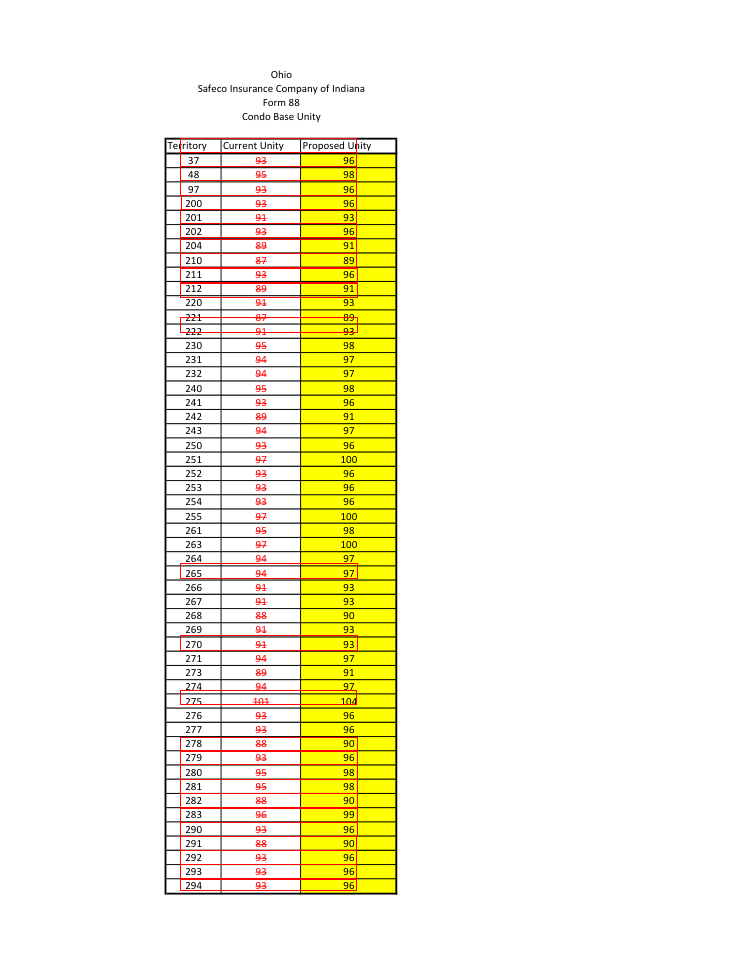

1 26 3
RAW HEADERS [_TableCellModelOutput(label='table column header', confidence=0.9921385645866394, bbox=(180.86487952145663, 138.2407819574529, 356.79094210537994, 152.0381681268865))]
RAW ROWS [_TableCellModelOutput(label='table row', confidence=0.9994983673095703, bbox=(180.69243517788973, 793.9459173029119, 357.08024874600494, 807.9643499200994)), _TableCellModelOutput(label='table row', confidence=0.9521975517272949, bbox=(180.8104352084073, 635.4361516779119, 357.28479281338775, 650.7357122247869)), _TableCellModelOutput(label='table row', confidence=0.9994599223136902, bbox=(180.73574915799227, 864.9843084161931, 356.9109219637784, 879.1261541193181)), _TableCellModelOutput(label='table row', confidence=0.9992608428001404, bbox=(180.73689356717196, 239.05323236638844, 356.9445523348721, 253.3611547296697)), _TableCellModelOutput(label='table row', confidence=0.9997487664222717, bbox=(180.77641573819247, 180.8201925104314, 356.76521578702057, 195.0712148492986)), _TableCellMode

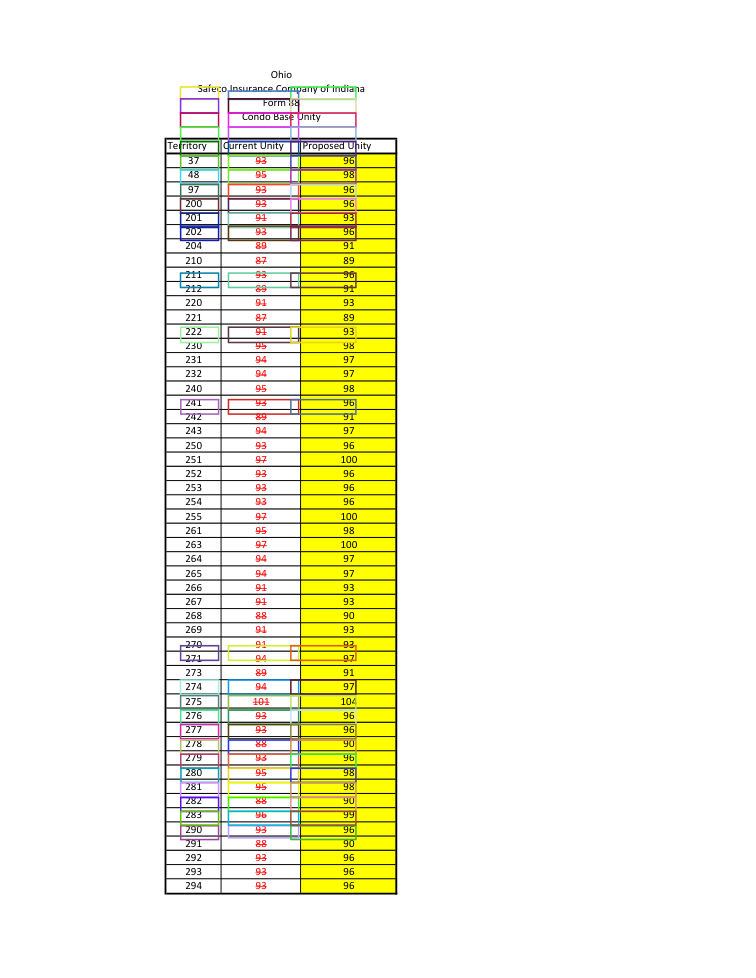

In [6]:
from typing import List, Literal, Union
from pathlib import Path
import random

import fitz

from src.tables.utils import doc_to_imgs
from src.schemas import TableElement, Bbox
from src.tables import ml
from src import visualization
from src import utils


reload(ml)


def ingest(
    doc: fitz.Document, table_format: Literal["str", "markdown", "html"] = "str"
) -> List[TableElement]:
    # try:
    #     from src.tables.ml import find_table_bboxes, get_table_content
    # except ImportError as e:
    #     raise ImportError(
    #         "Table detection and extraction requires the `torch`, `torchvision` and `transformers` libraries to be installed."
    #     )

    pdf_as_imgs = doc_to_imgs(doc)

    pages_with_tables = {}
    for page_num, img in enumerate(pdf_as_imgs):
        pages_with_tables[page_num] = ml.find_table_bboxes(img)
        print(f"Page {page_num} has {len(pages_with_tables[page_num])} tables")

    tables = []
    for page_num, table_bboxes in pages_with_tables.items():
        page = doc[page_num]
        page_dims = (page.rect.width, page.rect.height)
        for table_bbox in table_bboxes:
            table = ml.get_table_content(page_dims, img, table_bbox.bbox, doc)

            print("Running OCR on table", table_bbox)
            table._run_ocr(page)

            if table_format == "str":
                table_text = table.to_str()
            elif table_format == "markdown":
                table_text = table.to_markdown_str()
            elif table_format == "html":
                table_text = table.to_html_str()

            tables.append(
                table
                # TableElement(
                #     bbox=Bbox(
                #         page=page_num,
                #         x0=table_bbox.bbox[0],
                #         y0=table_bbox.bbox[1],
                #         x1=table_bbox.bbox[2],
                #         y1=table_bbox.bbox[3],
                #         page_width=page.rect.width,
                #         page_height=page.rect.height,
                #     ),
                #     text=table_text,
                # )
            )

    return tables


def draw_bboxes(
    file: Union[str, Path, fitz.Document],
    # cells: List[Union[_TableDataCell, _TableHeaderCell]],
    cells,
    page_nums: List[int] = None,
) -> fitz.Document:

    pdf = utils.load_doc(file)

    for page in pdf:
        page.wrap_contents()
        print(len(cells))

        for cell in cells:
            # Assuming all cells are on the first page for simplicity
            if page.number != 0:
                continue

            r = fitz.Rect(cell.bbox)
            color = (
                random.randint(0, 255) / 256,
                random.randint(0, 255) / 256,
                random.randint(0, 255) / 256,
            )
            page.draw_rect(r, color, width=1.5)  # You can adjust the width as needed

    return pdf


# doc_path = "../evals/data/tables/naic-numerical-list-of-companies-page-94.pdf"
# doc_path = "../evals/data/tables/underwriting-loss-and-profit.pdf"
# doc_path = "../evals/data/tables/OH_Condo_TerrBaseRates_Mock.pdf"
# # doc_path = "../evals/data/tables/underwriting-loss-and-profit.pdf"
# doc = utils.load_doc(doc_path)

res = ingest(doc, table_format="html")

# print(res)
# display("TEXT", res[0].text)
cells = []
if res[0].headers:
    for header in res[0].headers:
        cells.extend(header.cells)

    print("Num Headers", len(res[0].headers))
    print("Num Headers cols", len(res[0].headers[0].cells))
for row in res[0].rows:
    cells.extend(row.cells)


print("cells", len(cells), cells)
print("Num Rows", len(res[0].rows))
# print("Num Headers", len(res[0].headers))
# print("Num Headers cols", len(res[0].headers[0].cells))

print("BBOX", res[0].bbox)
marked_up_doc = draw_bboxes(doc, cells, page_nums=[0])
visualization.display_doc(marked_up_doc, page_nums=[0])

In [85]:
from IPython.display import Markdown


table_bbox = res[0]

parsed_res = TableElement(
    bbox=Bbox(
        page=0,
        x0=table_bbox.bbox[0],
        y0=table_bbox.bbox[1],
        x1=table_bbox.bbox[2],
        y1=table_bbox.bbox[3],
        page_width=doc[0].rect.width,
        page_height=doc[0].rect.height,
    ),
    text=table_bbox.to_markdown_str(),
)

# print(parsed_res.text)
#
Markdown(parsed_res.text)

|  | ar                | ars
6,603    | 6,603
0,951
5,060
       |  
034      | 3,577
,012
       |  
,685
33,367     | 33,367      |             |  |  |  |  |
|  |                   | 76           | 76
82
34                 |            | 13
2              | 1                 |             |             |  |  |  |  |
|  | 2018              | Ratio
100    | 100
100
47.0
            |      
1.4  | 17.9
3.3
         |      
1.7         |             |             |  |  |  |  |
|  | ar                | ars
5,098    | 5,098
0,968
0,641        | ,894       | 3,567
,537        | ,864
82,503       | 82,503      |             |  |  |  |  |
|  | Yea
ment          | Dolla
69,805 | 69,805
73,450
34,490
    |    
1,002, | 12,513
2,416,
    |    
1,158,
51,58  | 51,58       |             |  |  |  |  |
|  | 019
Year Sta
OHIO | atio
100     | 100
100
74.9
            |  
2.0      | 17.6
3.0
         |  
1.7             |             |             |  |  |  |  |
|  | 20
Five Y         | Ra
1         | 1
1
7
                   |            | 1
                |      
5           | 5           | on).        |  |  |  |  |
|  | ear
F             | llars
8,454  | 8,454
7,396
8,353
       |    
5,050  | 7,130
7,267
      |    
5,445
023,245 | 023,245     | deviatio    |  |  |  |  |
|  | Ye                | Doll
64,208  | 64,208
67,137
50,318
    |    
1,335  | 11,307
1,987
     |    
1,075
66,0    | 66,0
costs. | tten at a d |  |  |  |  |
|  | 020               | atio
100     | 100
100
70.4             | 1.9        | 17.5
3.7          | 1.9               | uisition    | es if wri   |  |  |  |  |
|  | 20                | Ra           |                          |            |                   |                   | acqu        |  rate       |  |  |  |  |

In [103]:
from src import utils
from src.tables import parse

reload(parse)

doc_path = "../evals/data/tables/naic-numerical-list-of-companies-page-94.pdf"
doc_path = "../evals/data/tables/4._OH_HO_APC_R54845_Property_-Casualty_Underwriting_Profit_&_Loss_Statement.pdf"
# doc_path = "../evals/data/tables/OH_Condo_TerrBaseRates_Mock.pdf"
doc = utils.load_doc(doc_path)

res = parse.ingest(doc, table_format="str", doc[0])

[_TableModelOutput(label='table', confidence=0.998865008354187, bbox=(56.02708435058594, 180.1764678955078, 702.3534545898438, 460.6815185546875))]
[_TableModelOutput(label='table', confidence=0.9995294809341431, bbox=(56.569820404052734, 173.6012420654297, 701.114501953125, 459.6762390136719))]


TypeError: get_table_content() missing 1 required positional argument: 'page'

In [28]:
from IPython.display import Markdown

Markdown(res[0].text)

+--+-------------------+---------+-------------------------+-----------------------+-------------------------+-----------------------+---------------+-------------+----------------------+----------------------+--------------------+---------------------+
|  |                   |         |                         | 533,367               |                         | ear                   | ollars
R      |             | 66,603
00,951
15,060 | 15,060
    
  
1,034 | 1,034
13,577
5,012 | 5,012
    
  
8,685 |
+--+-------------------+---------+-------------------------+-----------------------+-------------------------+-----------------------+---------------+-------------+----------------------+----------------------+--------------------+---------------------+
|  | 8                 | o       | 0
7
0
8
0
3             | 0
3
4                 | 4
9
1
3                 | 3
7                   |               |             |                      |                      |                    |                     |
+--+-------------------+---------+-------------------------+-----------------------+-------------------------+-----------------------+---------------+-------------+----------------------+----------------------+--------------------+---------------------+
|  | 2018              | Ratio   | 100
100
47.0            | 47.0
     
1.4        | 1.4
17.9
3.3            | 3.3
     
1.7         | 3             |             |                      |                      |                    |                     |
+--+-------------------+---------+-------------------------+-----------------------+-------------------------+-----------------------+---------------+-------------+----------------------+----------------------+--------------------+---------------------+
|  | ear               | llars   | 5,098
0,968
0,641       | 0,641
2,894           | 2,894
3,567
6,537       | 6,537
8,864           | 582,503       |             |                      |                      |                    |                     |
+--+-------------------+---------+-------------------------+-----------------------+-------------------------+-----------------------+---------------+-------------+----------------------+----------------------+--------------------+---------------------+
|  | Ye
tement
O       | Dol     | 69,80
73,45
34,49       | 34,49
     
1,002     | 1,002
12,51
2,416       | 2,416
     
1,158     | 51,5          |             |                      |                      |                    |                     |
+--+-------------------+---------+-------------------------+-----------------------+-------------------------+-----------------------+---------------+-------------+----------------------+----------------------+--------------------+---------------------+
|  | 2019
Five Year
OH | Ratio   | 4
100
6
100
3
74.9      | 3
74.9
     
0
2.0    | 0
2.0
0
17.6
7
3.0      | 7
3.0
     
5
1.7     | 45            | tion).      |                      |                      |                    |                     |
+--+-------------------+---------+-------------------------+-----------------------+-------------------------+-----------------------+---------------+-------------+----------------------+----------------------+--------------------+---------------------+
|  | Year              | Dollars | 208,454
137,396
318,353 | 318,353
     
335,050 | 335,050
307,130
987,267 | 987,267
     
075,445 | 6,023,2       | a devia     |                      |                      |                    |                     |
+--+-------------------+---------+-------------------------+-----------------------+-------------------------+-----------------------+---------------+-------------+----------------------+----------------------+--------------------+---------------------+
|  |                   | D       | 0
64,
0
67,
4
50,       | 4
50,
9
1,3           | 9
1,3
5
11,
7
1,9       | 7
1,9
9
1,0           | 66
ion costs. | written at  |                      |                      |                    |                     |
+--+-------------------+---------+-------------------------+-----------------------+-------------------------+-----------------------+---------------+-------------+----------------------+----------------------+--------------------+---------------------+
|  | 2020              | Ratio   | 100
100
70.4            | 70.4
    
1.9         | 1.9
17.5
3.7            | 3.7
    
1.9          | acquisiti     | rates if w  |                      |                      |                    |                     |
+--+-------------------+---------+-------------------------+-----------------------+-------------------------+-----------------------+---------------+-------------+----------------------+----------------------+--------------------+---------------------+
|  | ar                |         | 73
01
74                | 74
  
17              | 17
41
11                | 11
  
17              | 59
her a      | ual r       |                      |                      |                    |                     |
+--+-------------------+---------+-------------------------+-----------------------+-------------------------+-----------------------+---------------+-------------+----------------------+----------------------+--------------------+---------------------+